### import

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt

### 데이터 전처리

In [2]:
df = pd.read_csv('data_preprocessed.csv')

In [3]:
df_expanded = pd.read_csv('data_preprocessed_expanded.csv')

In [4]:
# dataset을 window_size 만큼씩 잘라서 batch로 만들어주는 함수
def make_dataset_batch(df, window_size = 24):
    df = df.reset_index(drop=True)
    label = df.pop('target')
    df_list = []
    label_list = []
    for i in range(int(len(df) - window_size)):
        df_list.append(np.array(df.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size-1]))
    return np.array(df_list), np.array(label_list)

In [5]:
df_expanded.shape[0] # 4 * 2 * 16 * 2 * 24 * 638

3919872

### LSTM 불러오기 및 평가

In [6]:
# 학습한 LSTM 모델 불러오기
models_LSTM = {}
weights_path = 'LSTM_50_20/'
for county in range(16):
    for is_business in range(2):
        for product_type in range(4):
            for is_consumption in range(2):
                idx = str(county) + '_' + str(is_business) + '_' + str(product_type) + '_' + str(is_consumption)
                models_LSTM[idx] = Sequential([
                    LSTM(50, input_shape=(24, 33), return_sequences=True),
                    LSTM(20, return_sequences=False),
                    Dense(1, name='output')
                ])
                models_LSTM[idx].load_weights(weights_path + 'LSTM_50_20_' + idx + '.h5')
                models_LSTM[idx].compile(optimizer='adam', loss='mae')

In [7]:
# LSTM 모델 평가
def test_models_LSTM(models_LSTM):
    global df_expanded
    test_evaluation_result_LSTM = {}
    for county in range(16):
        for is_business in range(2):
            for product_type in range(4):
                for is_consumption in range(2):
                    data = df_expanded[(df_expanded['is_business'] == is_business)
                                & (df_expanded['is_consumption'] == is_consumption)
                                & (df_expanded['county_' + str(county)] == 1)
                                & (df_expanded['product_type_' + str(product_type)] == 1)]
                    data = data.drop(columns=['year', 'quarter', 'month', 'week', 'hour', 'day_of_year', 'day_of_month', 'day_of_week',
                                            'is_business',
                                            'is_consumption',
                                            'county_0',
                                            'county_1',
                                            'county_2',
                                            'county_3',
                                            'county_4',
                                            'county_5',
                                            'county_6',
                                            'county_7',
                                            'county_8',
                                            'county_9',
                                            'county_10',
                                            'county_11',
                                            'county_12',
                                            'county_13',
                                            'county_14',
                                            'county_15',
                                            'product_type_0',
                                            'product_type_1',
                                            'product_type_2',
                                            'product_type_3'
                                            ])
                    
                    df_list, label_list = make_dataset_batch(data)

                    # 스플릿
                    X_train, X_test = train_test_split(df_list, test_size=0.2, shuffle=False)
                    y_train, y_test = train_test_split(label_list, test_size=0.2, shuffle=False)

                    idx = str(county) + '_' + str(is_business) + '_' + str(product_type) + '_' + str(is_consumption)
                    print(idx)
                    test_evaluation_result_LSTM[idx] = models_LSTM[idx].evaluate(X_test, y_test)
    return test_evaluation_result_LSTM
                    

In [8]:
test_evaluation_result_LSTM = test_models_LSTM(models_LSTM)

0_0_0_0
96/96 [==============================] - 1s 2ms/step - loss: 0.0015
0_0_0_1
96/96 [==============================] - 1s 2ms/step - loss: 0.0025
0_0_1_0
96/96 [==============================] - 1s 2ms/step - loss: 395.4287
0_0_1_1
96/96 [==============================] - 1s 3ms/step - loss: 488.8879
0_0_2_0
96/96 [==============================] - 1s 3ms/step - loss: 3.1155
0_0_2_1
96/96 [==============================] - 1s 2ms/step - loss: 10.5713
0_0_3_0
96/96 [==============================] - 1s 2ms/step - loss: 1363.3361
0_0_3_1
96/96 [==============================] - 1s 2ms/step - loss: 1437.1045
0_1_0_0
96/96 [==============================] - 1s 2ms/step - loss: 37.4689
0_1_0_1
96/96 [==============================] - 1s 2ms/step - loss: 752.2841
0_1_1_0
96/96 [==============================] - 1s 2ms/step - loss: 132.2460
0_1_1_1
96/96 [==============================] - 1s 2ms/step - loss: 662.4415
0_1_2_0
96/96 [==============================] - 1s 2ms/step - loss: 4

In [9]:
pd.DataFrame.from_dict(data = test_evaluation_result_LSTM, orient='index')[0].mean()

138.4995272505655

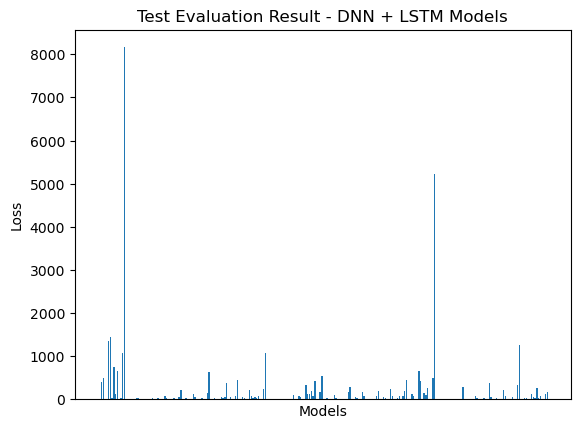

In [10]:
# LSTM 모델 평가 결과 시각화
import matplotlib.pyplot as plt

# test_evaluation_result_LSTM 시각화
plt.bar(range(len(test_evaluation_result_LSTM)), test_evaluation_result_LSTM.values())
plt.xlabel('Models')
plt.ylabel('Loss')
plt.title('Test Evaluation Result - DNN + LSTM Models')
plt.xticks([])
plt.show()


### DNN 불러오기

In [11]:
# 학습한 DNN 모델 불러오기
model_DNN = Sequential([
    Input(63),
    Dense(100, activation='relu'),
    Dense(300, activation='relu'),
    Dense(600, activation='relu'),
    Dense(300, activation='relu'),
    Dense(100, activation='relu'),
    Dense(60, activation='relu'),
    Dense(30, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1, name='output')
])

file_path = ''

model_DNN.load_weights(file_path + 'DNN_model_weights.h5')

model_DNN.compile(optimizer='adam', loss='mae')

### DNN + LSTM 평가

In [12]:
# LSTM 모델 중 test loss가 70 이상인 모델들을 DNN 모델로 대체
DNN_list = []
for county in range(16):
    for is_business in range(2):
        for product_type in range(4):
            for is_consumption in range(2):
                idx = str(county) + '_' + str(is_business) + '_' + str(product_type) + '_' + str(is_consumption)
                if 70 < test_evaluation_result_LSTM[idx]:
                    DNN_list.append(idx)

In [13]:
len(DNN_list)

64

In [14]:
def test_models_DNN_LSTM(model_DNN, models_LSTM):
    global df, DNN_list
    test_evaluation_result = {}
    for county in range(16):
        for is_business in range(2):
            for product_type in range(4):
                for is_consumption in range(2):
                    data = df[(df['is_business'] == is_business)
                                & (df['is_consumption'] == is_consumption)
                                & (df['county_' + str(county)] == 1)
                                & (df['product_type_' + str(product_type)] == 1)]
                    if data.shape[0] != 0:
                        idx = str(county) + '_' + str(is_business) + '_' + str(product_type) + '_' + str(is_consumption)
                        if idx in DNN_list:
                            # 스플릿
                            X_train, X_test = train_test_split(data, test_size=0.2, shuffle=False)
                            y_train = X_train.pop('target')
                            y_test = X_test.pop('target')
                            X_test = np.asarray(X_test).astype('float32')
                            y_test = np.asarray(y_test).astype('float32')

                            print(idx)
                            test_evaluation_result[idx] = model_DNN.evaluate(X_test, y_test)
                        else:
                            data = data.drop(columns=['year', 'quarter', 'month', 'week', 'hour', 'day_of_year', 'day_of_month', 'day_of_week',
                                                    'is_business',
                                                    'is_consumption',
                                                    'county_0',
                                                    'county_1',
                                                    'county_2',
                                                    'county_3',
                                                    'county_4',
                                                    'county_5',
                                                    'county_6',
                                                    'county_7',
                                                    'county_8',
                                                    'county_9',
                                                    'county_10',
                                                    'county_11',
                                                    'county_12',
                                                    'county_13',
                                                    'county_14',
                                                    'county_15',
                                                    'product_type_0',
                                                    'product_type_1',
                                                    'product_type_2',
                                                    'product_type_3'
                                                    ])
                            df_list, label_list = make_dataset_batch(data)

                            # 스플릿
                            X_train, X_test = train_test_split(df_list, test_size=0.2, shuffle=False)
                            y_train, y_test = train_test_split(label_list, test_size=0.2, shuffle=False)
                            
                            print(idx)
                            test_evaluation_result[idx] = models_LSTM[idx].evaluate(X_test, y_test)
    return test_evaluation_result
                    

In [15]:
test_evaluation_result = test_models_DNN_LSTM(model_DNN, models_LSTM)

0_0_1_0
96/96 [==============================] - 0s 834us/step - loss: 75.8242
0_0_1_1
96/96 [==============================] - 0s 807us/step - loss: 58.8170
0_0_2_0
96/96 [==============================] - 0s 2ms/step - loss: 3.5255
0_0_2_1
96/96 [==============================] - 0s 2ms/step - loss: 9.8649
0_0_3_0
96/96 [==============================] - 0s 770us/step - loss: 217.9493
0_0_3_1
96/96 [==============================] - 0s 843us/step - loss: 134.2004
0_1_0_0
96/96 [==============================] - 0s 2ms/step - loss: 41.5609
0_1_0_1
96/96 [==============================] - 0s 906us/step - loss: 80.1730
0_1_1_0
96/96 [==============================] - 0s 802us/step - loss: 29.9507
0_1_1_1
96/96 [==============================] - 0s 641us/step - loss: 74.5859
0_1_2_0
92/92 [==============================] - 0s 2ms/step - loss: 5.6430
0_1_2_1
92/92 [==============================] - 0s 2ms/step - loss: 53.1682
0_1_3_0
96/96 [==============================] - 0s 845us/step 

In [16]:
# test_evaluation_result 평균
pd.DataFrame.from_dict(data = test_evaluation_result, orient='index')[0].mean()

52.237993980231494

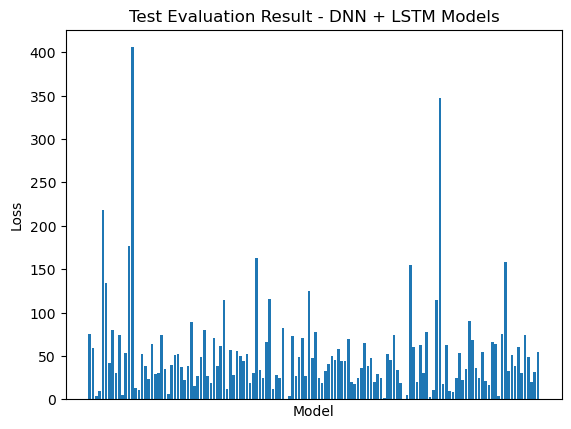

In [17]:
# test_evaluation_result 시각화
plt.bar(range(len(test_evaluation_result)), test_evaluation_result.values())
plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Test Evaluation Result - DNN + LSTM Models')
plt.xticks([])
plt.show()
